In [4]:
#

In [ ]:
# https://www.kaggle.com/myonin/music-recommendation-random-forest-xgboost

In [3]:
from sklearn import cross_validation, grid_search, metrics, ensemble
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [5]:
#

In [6]:
df = pd.read_csv('./train.csv')

In [7]:
df_sample = df.sample(frac=0.01)

In [9]:
songs = pd.read_csv('./songs.csv')

In [12]:
df_songs = pd.merge(df_sample, songs, on='song_id', how='left')

In [13]:
members = pd.read_csv('./members.csv')

In [14]:
df_songs_members = pd.merge(df_songs, members, on='msno', how='left')

In [15]:
#

In [16]:
df_songs_members.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73774 entries, 0 to 73773
Data columns (total 18 columns):
msno                      73774 non-null object
song_id                   73774 non-null object
source_system_tab         73531 non-null object
source_screen_name        69609 non-null object
source_type               73552 non-null object
target                    73774 non-null int64
song_length               73774 non-null int64
genre_ids                 72568 non-null object
artist_name               73774 non-null object
composer                  56936 non-null object
lyricist                  41966 non-null object
language                  73773 non-null float64
city                      73774 non-null int64
bd                        73774 non-null int64
gender                    44027 non-null object
registered_via            73774 non-null int64
registration_init_time    73774 non-null int64
expiration_date           73774 non-null int64
dtypes: float64(1), int64(7), obj

In [18]:
df_songs_members.isnull().sum()/df_songs_members.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.329384
source_screen_name         5.645620
source_type                0.300919
target                     0.000000
song_length                0.000000
genre_ids                  1.634722
artist_name                0.000000
composer                  22.823759
lyricist                  43.115461
language                   0.001355
city                       0.000000
bd                         0.000000
gender                    40.321794
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [20]:
for i in df_songs_members.select_dtypes(include=['object']).columns:
    df_songs_members[i][df_songs_members[i].isnull()] = 'unknown'

In [21]:
df_songs_members = df_songs_members.fillna(value=0)

In [22]:
df_songs_members.registration_init_time = pd.to_datetime(df_songs_members.registration_init_time, format='%Y%m%d', errors='ignore')
df_songs_members['registration_init_time_year'] = df_songs_members['registration_init_time'].dt.year
df_songs_members['registration_init_time_month'] = df_songs_members['registration_init_time'].dt.month
df_songs_members['registration_init_time_day'] = df_songs_members['registration_init_time'].dt.day

In [23]:
df_songs_members.expiration_date = pd.to_datetime(df_songs_members.expiration_date,  format='%Y%m%d', errors='ignore')
df_songs_members['expiration_date_year'] = df_songs_members['expiration_date'].dt.year
df_songs_members['expiration_date_month'] = df_songs_members['expiration_date'].dt.month
df_songs_members['expiration_date_day'] = df_songs_members['expiration_date'].dt.day

In [24]:
df_songs_members.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,uhovNdbWCJ9XX96mEEcSOX//np6kjxBILpotKtyNdY0=,OAoO256Lt8HoWSkMaFH1jLdTaSLK+8izthhDLJ0MbkU=,my library,Local playlist more,local-library,1,229538,1609,Linkin Park,unknown,...,male,9,2010-07-13,2017-09-29,2010,7,13,2017,9,29
1,tVsxyPgF7Gv3lvlmCLTteUdVLWsEqhZg9rK87Sof5rQ=,byuTz6ji9Oac1y7eFS+ZrivnA1rND9Vos9exw+6VpGQ=,discover,Discover Chart,online-playlist,1,197799,1259,Wiley,unknown,...,female,9,2010-10-16,2017-09-09,2010,10,16,2017,9,9
2,UKqufH+8HxG0l4tvAyL4OqU9UGQRL4d5BVTFKUAp1jc=,Csi8/hzmKAaLcdkyUG1oSlJexTcDOvQukhKOs2ETe00=,discover,unknown,online-playlist,0,243983,458,郁可唯 (Yisa Yu),查查\NU,...,female,9,2010-10-25,2017-09-23,2010,10,25,2017,9,23
3,zJ5AqcGL4nS12S42aM5K9O1R1I8avNnVfpfFEUBxkxc=,9W/H8tPBKQ7VWmBctuQ6RabciYdr1l+/kg1YPDcPOlU=,my library,Local playlist more,local-library,1,260493,458,Eric 周興哲,Eric周興哲,...,male,4,2016-10-23,2017-09-07,2016,10,23,2017,9,7
4,XPkr7W1r2v/nj+BuUMInQFBrRNNVeZ/uPzBGIS5/Rq4=,EH+nzRuSscqbP1Xd8ulzTMCGLEjqdzdxCaR8Fgyh6VY=,search,Search,song,0,229537,1259,Wiz Khalifa,unknown,...,unknown,7,2013-11-28,2017-09-23,2013,11,28,2017,9,23


In [25]:
df_songs_members['registration_init_time'] = df_songs_members['registration_init_time'].astype('category')
df_songs_members['expiration_date'] = df_songs_members['expiration_date'].astype('category')


In [26]:
for col in df_songs_members.select_dtypes(include=['object']).columns:
    df_songs_members[col] = df_songs_members[col].astype('category')

In [27]:
for col in df_songs_members.select_dtypes(include=['category']).columns:
    df_songs_members[col] = df_songs_members[col].cat.codes

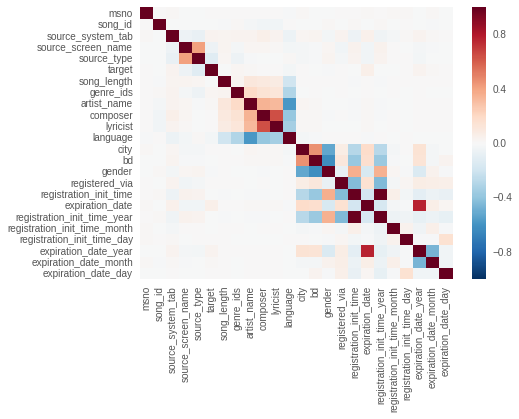

In [28]:
plt.figure(figsize=[7,5])
sns.heatmap(df_songs_members.corr())
plt.show()

In [30]:
df_songs_members = df_songs_members.drop(['expiration_date', 'lyricist'], 1)

In [31]:
#

In [32]:
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)

In [33]:
model.fit(df_songs_members[df_songs_members.columns[df_songs_members.columns != 'target']], df_songs_members.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
df_plot = pd.DataFrame({'features': df_songs_members.columns[df_songs_members.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

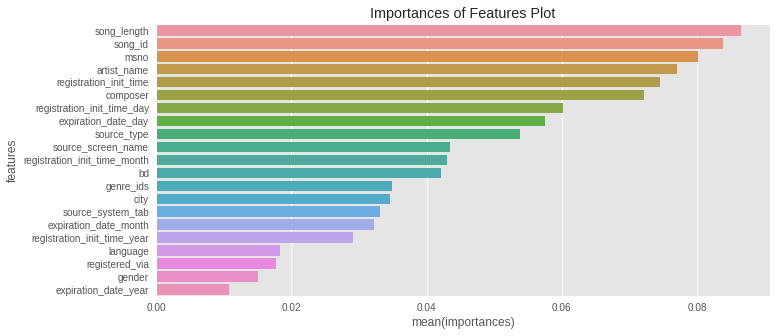

In [35]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [36]:
df_songs_members_ = df_songs_members.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [37]:
df_songs_members_.columns

Index(['msno', 'song_id', 'source_screen_name', 'source_type', 'target',
       'song_length', 'artist_name', 'composer', 'bd',
       'registration_init_time', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_day'],
      dtype='object')

In [38]:
#

In [39]:
target = df_songs_members_.pop('target')

In [40]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(df_songs_members_, target, test_size = 0.3)

In [41]:
#

In [42]:
model = xgb.XGBClassifier()

In [43]:
parameters_grid = { 'learning_rate' : [0.1, 0.2, 0.5], 'max_depth' : [5, 10, 15], 'n_estimators' : [150, 250, 300], 'min_child_weight' : [3, 5, 10] }

In [44]:
cv = cross_validation.StratifiedShuffleSplit(train_labels, n_iter = 3, test_size = 0.3)

In [45]:
grid_cv = grid_search.RandomizedSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

In [46]:
grid_cv.fit(train_data, train_labels)

RandomizedSearchCV(cv=StratifiedShuffleSplit(labels=[0 0 ... 0 1], n_iter=3, test_size=0.3, random_state=None),
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.1, 0.2, 0.5], 'max_depth': [5, 10, 15], 'n_estimators': [150, 250, 300], 'min_child_weight': [3, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='accuracy', verbose=0)

In [48]:
grid_cv.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [49]:
#

In [50]:
model_ = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)

In [51]:
model_.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=15,
       min_child_weight=5, missing=None, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [52]:
#

In [53]:
predict_labels = model_.predict(test_data)

In [54]:
print(metrics.classification_report(test_labels, predict_labels))

             precision    recall  f1-score   support

          0       0.63      0.59      0.61     10992
          1       0.62      0.66      0.64     11141

avg / total       0.62      0.62      0.62     22133

